# Monte Carlo Experiment wrt Bayes

In [1]:
import collections
from collections import Counter
import math
import string
import logging
import random
import numpy as np
import pandas as pd
from itertools import permutations
from sympy.utilities.iterables import partitions
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

### Test Variables

In [2]:
prior = [1/2, 1/3, 1/6]
n = 3
k = 3

## Functions

---
**gen_col** generates a non-unform random sample of size n according to the prior

In [3]:
def gen_col(n, prior):
    letters = ['a', 'b', 'c']
    return np.random.choice(letters, n, p=prior).tolist()

In [4]:
a = gen_col(n, prior)
print(a)

['a', 'c', 'c']


---
**gen_index_list** provides a list of lists containing indices to the adversary

In [25]:
def gen_index_list(letter_list):
    ind_x = []
    ind_y = []
    ind_z = []
    index_list = []
    i = 0
    for x in letter_list:
        if x=='a':
            ind_x.append(i)
        elif x == 'b':
            ind_y.append(i)
        elif x == 'c':
            ind_z.append(i)
        else:
            raise Exception("x != a, b, c")
        i = i + 1
    index_list.append(ind_x)
    index_list.append(ind_y)
    index_list.append(ind_z)
    return index_list

In [7]:
il = gen_index_list(a)
print("List of indices")
print(il)
print("Sorted by length of block")
il.sort(key=len, reverse=True)
print(il)

List of indices
[[0], [], [1, 2]]
Sorted by length of block
[[1, 2], [0], []]


---
**index_list_to_guess** acts as the adversary. It takes as input a list of indices, sorts them by size, and associates 'a', 'b', and 'c' with the lists. Outputs a guess column of letters.

In [26]:
def index_list_to_guess(index_list, n):
    guess_list = []
    random.shuffle(index_list)
    index_list.sort(key=len, reverse=True)
    d2b = {'a': index_list[0], 'b': index_list[1], 'c': index_list[2]}
    for i in range(n):
        if i in d2b['a']:
            guess_list.append('a')
        elif i in d2b['b']:
            guess_list.append('b')
        elif i in d2b['c']:
            guess_list.append('c')
        else:
            raise Exception("issue generating guess list")
    return guess_list

In [9]:
i2g = index_list_to_guess(il, n)
print(i2g)

['b', 'a', 'a']


In [10]:
a == i2g

False

---
**bayes_test** 
- generates the column
- generates the index partition
- provides the index partition to the adversary
- adversary makes guess
- checks if guess was correct

In [11]:
n = 3
prior = [1/3, 1/3, 1/3]
col = gen_col(n, prior)## Client has a plaintext column
print("col: ", col)
index_list = gen_index_list(col) ## Generate index partition
print("list of indices: ", index_list)
guess_list = index_list_to_guess(index_list, n) ## Index partition to adversary, guess
print("guess list: ", guess_list)
trust_value = (col == guess_list)
logging.info("*** True or False? *** -\n {}".format(trust_value))
print("trust value: ", trust_value)

col:  ['b', 'a', 'a']
list of indices:  [[1, 2], [0], []]
guess list:  ['b', 'a', 'a']
trust value:  True


In [12]:
def bayes_test(n, prior):
    col = gen_col(n, prior)## Client has a plaintext column
    logging.info("*** Plaintext Column *** -\n {}".format(col))
    index_list = gen_index_list(col) ## Generate index partition
    guess_list = index_list_to_guess(index_list, n) ## Index partition to adversary, guess
    trust_value = (col == guess_list)
    logging.info("*** True or False? *** -\n {}".format(trust_value))
    return trust_value

In [13]:
bayes_test(n, prior)

False

In [ ]:
logging.getLogger().setLevel(logging.INFO)

In [ ]:
logging.getLogger().setLevel(logging.WARNING)

---
**run_tests** runs `bayes_test` for a set number of times and outputs the success rate

In [14]:
def run_tests(num_tests, n, prior):
    yay = 0
    for i in range(num_tests):
        val = bayes_test(n, prior)
        if val == True:
            yay = yay + 1
    return yay/num_tests

# Bayes Tests

### Uniform

At n = 10, posterior Bayes ~.166.
Trials: 1M, .166

In [14]:
num_tests = 1000000
n = 10
prior = (1/3, 1/3, 1/3)
success = run_tests(num_tests, n, prior)
print("Success rate: ", success)

Success rate:  0.166688


### Nonuniform

At n = 3, posterior Bayes ~.4027

Trials: 1M, success rate: ~.402

In [15]:
num_tests = 1000000
n = 3
prior = (1/2, 1/3, 1/6)
success = run_tests(num_tests, n, prior)
print("Success rate: ", success)

Success rate:  0.402216


Posterior bayes vulnerability for n = 10: approx .51

Trials: 1M, success rate: ~.51

In [16]:
num_tests = 1000000
n = 10
prior = (1/2, 1/3, 1/6)
success = run_tests(num_tests, n, prior)
print("Success rate: ", success)

Success rate:  0.510227


Posterior bayes vuln for n = 20 is approx 0.66

Trials: 500, success rate: .67

In [17]:
num_tests = 500
n = 20
prior = [1/2, 1/3, 1/6]
success_rate = run_tests(num_tests, n, prior)
print("Your success rate: ", success_rate)

Your success rate:  0.67


## C/P Bayes Functions

In [15]:
from sympy.utilities.iterables import partitions
from sympy.functions.combinatorial.numbers import stirling

In [16]:
def calc_set_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    frac = num / den
    return frac

In [17]:
def calc_max_prob(p, Pi):
    Pi.sort(reverse=True)
    frac = 1
    ind = 0
    val = -1
    for key in sorted(p.keys(), reverse=True):
        val = p[key]
        for i in range(val):
            frac = frac * pow(Pi[ind], key)
            ind = ind + 1
    return frac

In [18]:
def nonuni_post_bayes_vuln(n, k, Pi):
    pbvsum = 0
    for p in partitions(n, m=k):  
        num = calc_set_partitions(n,p)
        frac = calc_max_prob(p, Pi)
        val = num * frac
        pbvsum = pbvsum + val
    return pbvsum

## Comparing Bayes Posterior Vuln and Experimental Success

In [19]:
def bayes_post_vs_success(n_range, k, probs, num_tests):
    post_bayes_vs = []
    success = []
    for i in range(n_range):
        post_bayes_vs.append(nonuni_post_bayes_vuln(i+1, k, probs))
        success.append(run_tests(num_tests, i+1, probs))
    df = pd.DataFrame(
        {'posterior':post_bayes_vs,
         'success':success
        }
    )
    return df

In [20]:
def graph_bayes_exp(n_range, df):
    x = [i+1 for i in range(n_range)]
    plt.plot(x, 'posterior', data=df, label="posterior")
    plt.plot(x, 'success', data=df, label="success")
    plt.xlabel("n values")
    plt.ylim(bottom = -.1, top = 1)
    plt.legend()
    plt.show()
    plt.close()

## n = 1- 200, 100K tests per n

### Non-uniform prior

Success rate and Bayes posterior vulnerability are almost perfectly matched

In [25]:
n_range = 200
k = 3
probs = [1/2, 1/3, 1/6]
num_tests = 100000
df_M = bayes_post_vs_success(n_range, k, probs, num_tests)
df_M

,posterior,success
0,0.5000000000,0.49922
1,0.4166666667,0.41544
2,0.4027777778,0.40229
3,0.3958333333,0.39472
4,0.4131944444,0.41286
5,0.4311342593,0.42961
6,0.4507137346,0.45018
7,0.4712416409,0.47083
8,0.4918954690,0.49233
9,0.5100027328,0.50987


In [26]:
df_M.to_csv(r'data\df_200_nonuni.csv', index = None, header=True) 

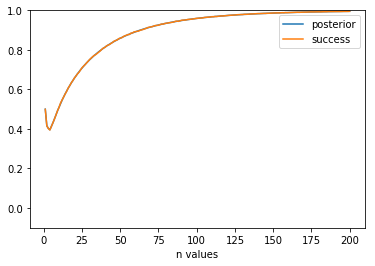

In [28]:
graph_bayes_exp(n_range, df_M)

### Uniform Prior

Odd results, too high for low n's, consistantly just above posterior for higher n's.

In [28]:
n_range = 200
k = 3
probs = [1/3, 1/3, 1/3]
num_tests = 100000
df_exp_uni = bayes_post_vs_success(n_range, k, probs, num_tests)
df_exp_uni

,posterior,success
0,0.3333333333,0.33446
1,0.2222222222,0.22384
2,0.1851851852,0.18327
3,0.1728395062,0.17082
4,0.1687242798,0.16865
5,0.1673525377,0.16770
6,0.1668952904,0.16859
7,0.1667428746,0.16810
8,0.1666920693,0.16834
9,0.1666751342,0.16569


In [29]:
df_exp_uni.to_csv(r'data\df_exp_uni.csv', index = None, header=True) 

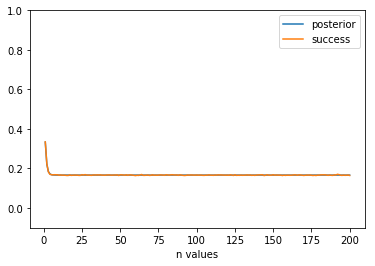

In [30]:
graph_bayes_exp(n_range, df_exp_uni)